In [2]:
MAIN_FOLDER = '.'

In [3]:
import pandas as pd
import numpy as np
import joblib
import os


#import all models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.model_selection as model_selection
import xgboost as xgb
import lightgbm as lgb

#import all metrics
import sklearn.metrics as metrics

import warnings
warnings.filterwarnings('ignore')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:

#read data
train = pd.read_csv(os.path.join(MAIN_FOLDER,"data/train.csv"))
test = pd.read_csv(os.path.join(MAIN_FOLDER,"data/train.csv"))

train.shape, test.shape

((5634, 17), (5634, 17))

In [5]:
train.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,0,Yes,Yes,43,No,DSL,No,Yes,No,No,No,No,Month-to-month,No,Mailed check,50.20,0
1,0,Yes,Yes,37,Yes,Fiber optic,No,Yes,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,95.15,0
2,0,No,No,35,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Credit card (automatic),85.95,1
3,0,Yes,No,69,No phone service,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),60.25,0
4,0,Yes,Yes,69,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),20.20,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     5634 non-null   int64  
 1   Partner           5634 non-null   object 
 2   Dependents        5634 non-null   object 
 3   tenure            5634 non-null   int64  
 4   MultipleLines     5634 non-null   object 
 5   InternetService   5634 non-null   object 
 6   OnlineSecurity    5634 non-null   object 
 7   OnlineBackup      5634 non-null   object 
 8   DeviceProtection  5634 non-null   object 
 9   TechSupport       5634 non-null   object 
 10  StreamingTV       5634 non-null   object 
 11  StreamingMovies   5634 non-null   object 
 12  Contract          5634 non-null   object 
 13  PaperlessBilling  5634 non-null   object 
 14  PaymentMethod     5634 non-null   object 
 15  MonthlyCharges    5634 non-null   float64
 16  Churn             5634 non-null   int64  


Get those columns which are of object type and those columns which are of int type

In [7]:
get_obj_cols = [col for col in train.columns if train[col].dtype == 'object']
get_int_cols = [col for col in train.columns if train[col].dtype != 'object']

# Response Encoding

[More info check this link](https://medium.com/@thewingedwolf.winterfell/response-coding-for-categorical-data-7bb8916c6dc1)

We will response encode the categorical data instead of using one hot encoding the categorical data. The below is the code for that.

In [8]:
#create a class response_encoding which fit and transform the categorical columns

class response_encoding:
  """
  This function is used to fit and transform the dataframe in one go.
  This is only made for binary classification problems.
  """
  def __init__(self,cols,target = 'Churn',alpha = 0, target_value = 1):
    """
    Parameters:
    -----------
    cols: list of categorical columns
    target: the target column
    alpha: the smoothing parameter
    target_value: the target value
    """
    self.cols = cols
    self.master_dict = {} #storing the original values
    self.alpha = alpha #smoothing parameter
    self.target = target
    self.target_value = 1
    
  def fit(self,df):
    alpha = self.alpha
    target = self.target
    for column in self.cols:
      unique_values = df[column].unique() #all unique values in that categorical column
      dict_values = {} #storing the response encoding values for target=1
      for value in unique_values:
        total = len(df[df[column]==value]) #the total no. of datapoints with 'value' catgeory
        sum_promoted = len(df[(df[column]==value) & (df[target]==self.target_value)]) #no. of all datapoints with category being 'value' and target=='yes'
        dict_values[value] = np.round((sum_promoted+alpha)/(total+alpha*len(unique_values)),2) #storing the obtained result in a dictionary
      dict_values['UNK']=0.5 #unknown categories that are not seen in train will be assigned a score of 0.5
      self.master_dict[column] = dict_values.copy() #storing the original values in a dictionary
    
    return None
    
  def transform(self,df):
    for column in self.cols:
      df[column] = df[column].map(self.master_dict[column]) #map the values in the column to the dictionary
    return df

In [9]:
#fit the response_encoding class to the train data
#response encoding all the categorical columns
resp_enc = response_encoding(cols=get_obj_cols,target='Churn',alpha=0.1)
resp_enc.fit(train)

train = resp_enc.transform(train)
test = resp_enc.transform(test)

train.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,0,0.20,0.15,43,0.25,0.19,0.41,0.22,0.39,0.41,0.34,0.33,0.43,0.17,0.19,50.20,0
1,0,0.20,0.15,37,0.29,0.42,0.41,0.22,0.23,0.41,0.34,0.31,0.43,0.33,0.46,95.15,0
2,0,0.33,0.31,35,0.29,0.19,0.15,0.40,0.23,0.16,0.30,0.31,0.11,0.33,0.15,85.95,1
3,0,0.20,0.31,69,0.26,0.19,0.15,0.40,0.23,0.16,0.30,0.31,0.03,0.17,0.17,60.25,0
4,0,0.20,0.15,69,0.25,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.03,0.17,0.17,20.20,0


In [10]:
#save the resp_enc object to a file
# with open('../model/resp_enc.pkl','wb') as f:
#     joblib.dump(resp_enc,f)

In [11]:
# train.to_csv('../data/train_encoded.csv',index=False)
# test.to_csv('../data/test_encoded.csv',index=False)

# Modelling

In [12]:
#split the data into x and y
x_train = train.drop(['Churn'],axis=1)
y_train = train['Churn']

x_test = test.drop(['Churn'],axis=1)
y_test = test['Churn']

Since this is an imbalanced classification we need to assign weights to the classes. We will use the below code to do that. This is specifically for XGBoost and it is not applicable for other models as specified in the official documentation. For other models we will use 'balanced'.

In [13]:
#for xgboost
#weight = no. of negative classes/no. of positive classes
weight = (y_train == 0).sum()/(y_train == 1).sum() 

We will be fitting Decision Tree Classifier, Random Forest Classifier, XGBoost Classifier and LightGBM Classifier.

In [152]:
models = {
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=420),
    'Random Forest': RandomForestClassifier(class_weight='balanced_subsample',n_jobs = -1,
                                            n_estimators=50, max_depth=10, random_state=420),  
    'XGBoost': xgb.XGBClassifier(scale_pos_weight = weight,use_label_encoder=False,
                                n_jobs = -1, random_state=420),
    'LightGBM': lgb.LGBMClassifier(class_weight='balanced', n_jobs = -1, random_state=420)
}

cv = model_selection.RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=420)

for model_name, model in models.items():
    print(model_name)
    for score in ["roc_auc", "f1", "precision", "recall"]:
        scores = model_selection.cross_val_score(model, x_train, y_train, scoring=score, cv=cv, n_jobs=-1)
        print(f"Mean {score}: {np.mean(scores):.2f}")
    print('\n')

Decision Tree
Mean roc_auc: 0.65
Mean f1: 0.48
Mean precision: 0.48
Mean recall: 0.48


Random Forest
Mean roc_auc: 0.83
Mean f1: 0.61
Mean precision: 0.57
Mean recall: 0.67


XGBoost
Mean roc_auc: 0.84
Mean f1: 0.63
Mean precision: 0.52
Mean recall: 0.80


LightGBM
Mean roc_auc: 0.82
Mean f1: 0.60
Mean precision: 0.52
Mean recall: 0.71




The best model is found to be XGBoost which had the large scores in both roc-auc, f1, precision and recall.

# Next Steps

* Hyperparameter tune the XGBoost model and validate it on test data.
* Study feature importance using Shapley values.
* Build python scripts to ensure future training can be done smoothly and can be reproduced.

# Hyperparameter tune the XGBoost

In [153]:
# !pip install optuna 
import optuna

In [155]:
def objective(trial,data=x_train,target=y_train):
    param = {
        #'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_int('n_estimators',100,1000),
        'max_depth': trial.suggest_categorical('max_depth', [i+1 for i in range(9)]),
        'random_state': 420,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'scale_pos_weight': weight
    }
    model = xgb.XGBClassifier(**param)  
    
    cv = model_selection.RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=420)

    scores = model_selection.cross_val_score(model, data, target, scoring="f1", cv=cv, n_jobs=-1)
    
    return np.mean(scores)

In [156]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-10-11 22:54:10,134] A new study created in memory with name: no-name-500fa055-75d5-43e6-a6b0-c66e2d9f21b4
[I 2021-10-11 22:54:13,592] Trial 0 finished with value: 0.6243299501202937 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 276, 'max_depth': 6, 'min_child_weight': 98}. Best is trial 0 with value: 0.6243299501202937.
[I 2021-10-11 22:54:20,304] Trial 1 finished with value: 0.6274569103745834 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.009, 'n_estimators': 443, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 1 with value: 0.6274569103745834.
[I 2021-10-11 22:54:26,891] Trial 2 finished with value: 0.6194273709952506 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02, 'n_estimators': 923, 'max_depth': 1, 'min_child_weight': 242}. Best is trial 1 with value: 0.6274569103745834.
[I 2021-10-11 22:54:32,178] Trial 3 finished with value: 0.6073111499764461 a

Number of finished trials: 50
Best trial: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.016, 'n_estimators': 884, 'max_depth': 8, 'min_child_weight': 89}


In [157]:
params = study.best_params
params['scale_pos_weight'] = weight
params['random_state'] = 420
model = xgb.XGBClassifier(**params)
cv = model_selection.RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=420)

In [158]:
for score in ["roc_auc", "f1", "precision", "recall"]:
  scores = model_selection.cross_val_score(model, x_train, y_train, scoring=score, cv=cv, n_jobs=-1)
  print(f"Mean {score}: {np.mean(scores):.2f}")

Mean roc_auc: 0.84
Mean f1: 0.63
Mean precision: 0.53
Mean recall: 0.78


Model performance on Test data
-----------------------------------
aoc: 0.86
f1: 0.65
precision: 0.54
recall: 0.81


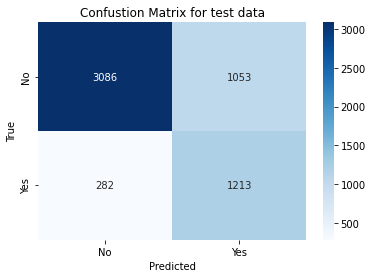

In [159]:
model.fit(x_train,y_test)
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:,1]

aoc = metrics.roc_auc_score(y_test,y_pred_proba)
f1 = metrics.f1_score(y_test,y_pred)
precision = metrics.precision_score(y_test,y_pred)
recall = metrics.recall_score(y_test,y_pred)
print("Model performance on Test data")
print("-"*35)
print(f"aoc: {aoc:.2}")
print(f"f1: {f1:.2}")
print(f"precision: {precision:.2}")
print(f"recall: {recall:.2}")

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(metrics.confusion_matrix(y_test,y_pred),
annot=True,
cmap='Blues',
fmt = 'd',
xticklabels=['No', 'Yes'],
yticklabels=['No', 'Yes']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confustion Matrix for test data')
plt.show()

# Model inferencing using SHAP

In [160]:
# !pip install shap

In [161]:
import shap

In [162]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(x_train)

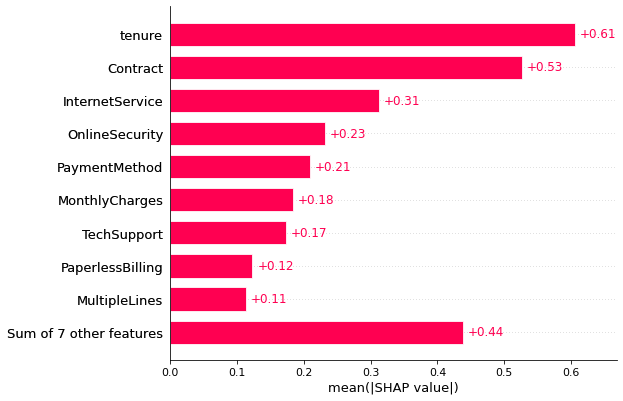

In [163]:
shap.plots.bar(shap_values)

In [164]:
#get top features with highest magnitude shap values
mean_shap = np.abs(shap_values.values).mean(0)

#getting those indices where mean shap values is greater than 0
imp_feat = np.argwhere(mean_shap>0)

#getting those indices of mean_shap values descending
vals_indice = np.argsort(mean_shap)[::-1] #descending

#the features with high magnitude
top_feat = x_train.columns[[i for i in vals_indice if i in imp_feat]]
x_train = x_train.loc[:,top_feat].copy()
x_test = x_test.loc[:,top_feat].copy()

print(f"No. of columns remove because of 0 mean Shapley Values: {len(imp_feat)}")

In [165]:
def objective(trial,data=x_train,target=y_train):
    param = {
        #'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_int('n_estimators',100,1000),
        'max_depth': trial.suggest_categorical('max_depth', [i+1 for i in range(9)]),
        'random_state': 420,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'scale_pos_weight': weight
    }
    model = xgb.XGBClassifier(**param)  
    
    cv = model_selection.RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=420)

    scores = model_selection.cross_val_score(model, data, target, scoring="f1", cv=cv, n_jobs=-1)
    
    return np.mean(scores)

In [166]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-10-11 23:00:20,942] A new study created in memory with name: no-name-ea62b65f-ef15-4e05-bc11-d343ebc1e16d
[I 2021-10-11 23:00:24,494] Trial 0 finished with value: 0.6275350921670838 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'n_estimators': 309, 'max_depth': 4, 'min_child_weight': 175}. Best is trial 0 with value: 0.6275350921670838.
[I 2021-10-11 23:00:32,602] Trial 1 finished with value: 0.6275837343520673 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.016, 'n_estimators': 736, 'max_depth': 6, 'min_child_weight': 53}. Best is trial 1 with value: 0.6275837343520673.
[I 2021-10-11 23:00:43,659] Trial 2 finished with value: 0.6152972994649669 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 454, 'max_depth': 6, 'min_child_weight': 3}. Best is trial 1 with value: 0.6275837343520673.
[I 2021-10-11 23:00:49,618] Trial 3 finished with value: 0.618935910312284 a

Number of finished trials: 50
Best trial: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.016, 'n_estimators': 986, 'max_depth': 2, 'min_child_weight': 98}


In [167]:
params = study.best_params
params['scale_pos_weight'] = weight
params['random_state'] = 420
model = xgb.XGBClassifier(**params)
cv = model_selection.RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=420)

In [168]:
for score in ["roc_auc", "f1", "precision", "recall"]:
  scores = model_selection.cross_val_score(model, x_train,
                                           y_train, scoring=score, cv=cv, n_jobs=-1)
  print(f"Mean {score}: {np.mean(scores):.2f}")

Mean roc_auc: 0.84
Mean f1: 0.63
Mean precision: 0.53
Mean recall: 0.78


Model performance on Test data
-----------------------------------
aoc: 0.86
f1: 0.64
precision: 0.53
recall: 0.8


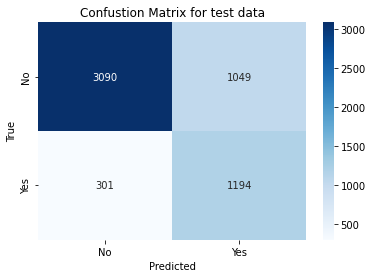

In [171]:
model.fit(x_train,y_test)
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:,1]

aoc = metrics.roc_auc_score(y_test,y_pred_proba)
f1 = metrics.f1_score(y_test,y_pred)
precision = metrics.precision_score(y_test,y_pred)
recall = metrics.recall_score(y_test,y_pred)
print("Model performance on Test data")
print("-"*35)
print(f"aoc: {aoc:.2}")
print(f"f1: {f1:.2}")
print(f"precision: {precision:.2}")
print(f"recall: {recall:.2}")

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(metrics.confusion_matrix(y_test,y_pred),
annot=True,
cmap='Blues',
fmt = 'd',
xticklabels=['No', 'Yes'],
yticklabels=['No', 'Yes']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confustion Matrix for test data')
plt.show()

In [172]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(x_train.loc[:,top_feat])

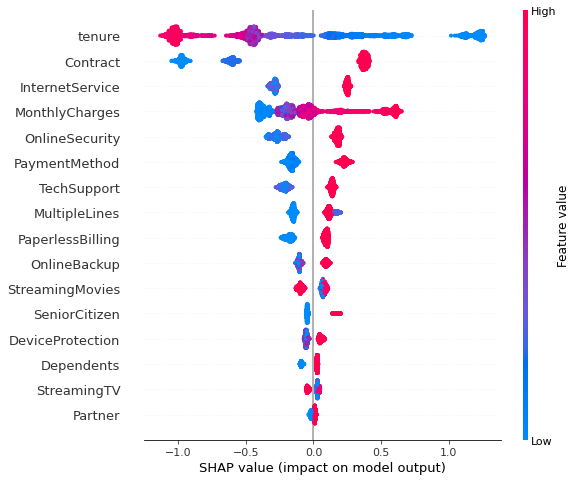

In [174]:
shap.summary_plot(shap_values)

In [146]:
resp_enc.master_dict

{'Contract': {'Month-to-month': 0.43,
  'One year': 0.11,
  'Two year': 0.03,
  'UNK': 0.5},
 'Dependents': {'No': 0.31, 'UNK': 0.5, 'Yes': 0.15},
 'DeviceProtection': {'No': 0.39,
  'No internet service': 0.07,
  'UNK': 0.5,
  'Yes': 0.23},
 'InternetService': {'DSL': 0.19, 'Fiber optic': 0.42, 'No': 0.07, 'UNK': 0.5},
 'MultipleLines': {'No': 0.25,
  'No phone service': 0.26,
  'UNK': 0.5,
  'Yes': 0.29},
 'OnlineBackup': {'No': 0.4,
  'No internet service': 0.07,
  'UNK': 0.5,
  'Yes': 0.22},
 'OnlineSecurity': {'No': 0.41,
  'No internet service': 0.07,
  'UNK': 0.5,
  'Yes': 0.15},
 'PaperlessBilling': {'No': 0.17, 'UNK': 0.5, 'Yes': 0.33},
 'Partner': {'No': 0.33, 'UNK': 0.5, 'Yes': 0.2},
 'PaymentMethod': {'Bank transfer (automatic)': 0.17,
  'Credit card (automatic)': 0.15,
  'Electronic check': 0.46,
  'Mailed check': 0.19,
  'UNK': 0.5},
 'StreamingMovies': {'No': 0.33,
  'No internet service': 0.07,
  'UNK': 0.5,
  'Yes': 0.31},
 'StreamingTV': {'No': 0.34,
  'No internet se

In [141]:
top_feat

Index(['Contract', 'OnlineSecurity', 'InternetService', 'TechSupport',
       'tenure', 'PaymentMethod', 'OnlineBackup'],
      dtype='object')